# Rasch (Nx1PL) MLTM
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [82]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt
from random import random, shuffle, choice, randint, uniform
import numpy

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape
from keras.optimizers import Adam
from keras import backend as K
from keras import constraints

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

nq = 10
n_traits = 5



In [83]:
generate_student_name()

'PHUTHY CORE '

In [84]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        z = K.concatenate([x,self.kernel], axis=0)
        p = K.prod(z, axis=0)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [85]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print( 1/(1+exp(-z)) )

2.0611536181902037e-09
4.5397868702434395e-05
0.01798620996209156
0.04742587317756678
0.11920292202211755
0.2689414213699951
0.5
0.7310585786300049
0.8807970779778823
0.9525741268224334
0.9820137900379085


In [86]:
class Question():
    def __init__(self, qix, nt=10, optimiser=None):
        #self.MAX_BETA = 15
        self.id = qix
        no_dummies = randint(1,(nt-1))
        print("no_dummies=",no_dummies)
        not_present=-20
        min_diff = 0
        max_diff = 8
        self.betas = [ not_present for _ in range(nt) ]
        print("nt=",nt)
        choices = [ x for x in range(nt) ]
        for _ in range(no_dummies):
            ch = random.choice(choices)
            choices.remove(ch)
            self.betas[ch]=randint(min_diff,max_diff)
        #print("Made q with betas:", self.betas)
        
        th = Input(shape=(nt,), name="user_theta")
        b_in = Input(shape=(nt,), name="beta_in")
        bvar = ProductLayer(nt, kernel_constraint=WeightClip(min_w=not_present, max_w=max_diff), minv=not_present,maxv=max_diff) # introduce nt trainable weights for the beta values
        b = bvar(b_in)
        dif = subtract([th,b])
        print("dif",dif.shape)
#         Pr = Dense(1, activation="sigmoid")(dif)
        Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid")(dif)
        print("Prs",Prs.shape)
        Pr = Lambda(lambda ps: K.prod(ps, axis=1), name="Pr_prod")(Prs)
        print("Pr",Pr.shape)
        Pr = Reshape((1,))(Pr)
        print("Pr",Pr.shape)
        model = Model(inputs=[th,b_in], outputs=Pr)
        #o = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(optimizer=optimiser, loss="binary_crossentropy")
        self.model = model
        self.pred_betas = bvar
        
        
# qs = [Question(qix, n_traits) for qix in range(10)]
# qs[0].model.summary()

# random.seed(666)
# qs = [Question(qix, n_traits) for qix in range(10)]
# for q in qs:
#     print(q.id, q.betas)

In [87]:
class Student():
    def __init__(self, nt=10, nq=20, optimiser=None):
        #self.MAX_BETA = 15
        self.name = generate_student_name()
        min_abil = 4
        max_abil = 12
        self.thetas = [ randint(min_abil, max_abil) for _ in range(nt) ]
        self.mastery = [0 for _ in range(nq)]
        self.o_practice = [0 for _ in range(nq)]
        self.h_practice = [0 for _ in range(nt)]
        #print("Made q with betas:", self.betas)
        th_in = Input(shape=(nt,), name="theta_in")
        b_in = Input(shape=(nt,), name="qn_beta")
        th_var = ProductLayer(nt, kernel_constraint=WeightClip(min_w=min_abil, max_w=max_abil), minv=min_abil, maxv=max_abil) # introduce nt trainable weights for the beta values
        th = th_var(th_in)
        dif = subtract([th,b_in])
        print("dif",dif.shape)
        Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid")(dif)
        print("Prs",Prs.shape)
        Pr = Lambda(lambda ps: K.prod(ps, axis=1), name="Pr_prod")(Prs)
        print("Pr",Pr.shape)
        Pr = Reshape((1,))(Pr)
        model = Model(inputs=[th_in,b_in], outputs=Pr)
        model.compile(optimizer=optimiser, loss="binary_crossentropy")
        self.model = model
        self.pred_theta = th_var

In [88]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=True
        student.mastery[q.id] = 1
    else:
        passed=False

    return passed

In [89]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
    print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        if b < 0:
            continue
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:        
        print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [90]:
random.seed(666)
qopt = Adam()
master_qs = [Question(qix, nt=n_traits, optimiser=qopt) for qix in range(nq)]
for q in master_qs:
    nocomps = len(q.betas)
    mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
    print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))

no_dummies= 4
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 4
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 2
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 2
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 5)
Prs (?, 5)
Pr (?,)
Pr (?, 1)
Q:0, difficulty=23.77 across 5 components
Q:1, difficulty=40.45 across 5 components
Q:2, difficulty=20.37 across 5 components
Q:3, difficulty=35.90 across 5 components
Q:4, difficulty=28.46 across 5 components
Q:5, difficulty=35.55 across 5 components
Q:6, difficulty=40.00 across 5 components
Q:7, difficulty=30.23 across 5 components
Q:8, difficulty=40.45 across 5 components
Q:9, difficulty=29.21 

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [91]:
Xs = {}
Tz = {}
ys = {}
alphas = {}
attempts = []
attempts_by_psi = {}
attempts_by_q = {}
no_tr_students = 100

# psi_opt = Adam(lr=0.1)
random.seed(42)
psi_list = [ Student(nt=n_traits, nq=len(master_qs), optimiser=qopt) for _ in range(no_tr_students)]
for psi in psi_list:
    print(psi.name, psi.thetas)
    
    

dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)
Prs (?, 5)
Pr (?,)
dif (?, 5)

In [92]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [93]:
user_budget = 100
user_patience = 10
for run in range(1):
    print("----{}\n".format(run))
    for psi in psi_list:
        spend=0
        psi.mastery = [0 for _ in range(nq)]
        qs = [ix for ix in range(len(master_qs))]
        print("* * * **** USER {}".format(psi.name))
        print("* * * * ** THETAS {}".format(psi.thetas))
            
        while(True):
            q_ct = 0
            qix = random.choice(qs)
            q = master_qs[qix]
            passed=False

            if psi.name not in attempts_by_psi:
                attempts_by_psi[psi.name]=[]
            
            if q not in attempts_by_q:
                attempts_by_q[q]=[]

            while not passed and q_ct<user_patience:
                passed = attempt_q(psi, q)
                tup = (psi, q, passed)
                attempts.append(tup)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                q_ct+=1

            if passed:
                print("passed")
                qs.remove(qix)
        
            spend += 1
        
            if qs == [] or spend>=user_budget:
                    print("* ** *QFIN USER {}".format(psi.name))
                    break

----0

* * * **** USER BIJYTH PHAH 
* * * * ** THETAS [7, 12, 4, 12, 7]
th,b [7, 12, 4, 12, 7] [-20, -20, 3, 0, 1]
p_pass=0.7292464656144853
th,b [7, 12, 4, 12, 7] [-20, -20, 3, 0, 1]
p_pass=0.7292464656144853
passed
th,b [7, 12, 4, 12, 7] [-20, 6, -20, -20, -20]
p_pass=0.9975273768433653
passed
th,b [7, 12, 4, 12, 7] [1, -20, 1, 2, 3]
p_pass=0.9330855736517897
passed
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
th,b [7, 12, 4, 12, 7] [-20, -20, 6, 1, 4]
p_pass=0.11354772291980764
passed
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.0048133451186

th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8, 6, 1]
p_pass=0.004813345118669635
th,b [7, 12, 4, 12, 7] [8, -20, 8,

p_pass=0.002248459172631866
th,b [4, 12, 7, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.002248459172631866
th,b [4, 12, 7, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.002248459172631866
th,b [4, 12, 7, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.002248459172631866
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [8, -20, 8, 6, 1]
p_pass=0.003368591230440685
th,b [4, 12, 7, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.002248459172631866
th,b [4, 12,

th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [9, 5, 7, 7, 7] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
passed
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass=0.14337943836228542
th,b [9, 5, 7, 7, 7] [8, -20, 8, 6, 1]
p_pass

th,b [8, 12, 11, 8, 4] [8, -20, 8, 6, 1]
p_pass=0.3996165187893718
passed
th,b [8, 12, 11, 8, 4] [-20, 0, -20, -20, -20]
p_pass=0.9999938558253978
passed
th,b [8, 12, 11, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.4999969279126989
th,b [8, 12, 11, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.4999969279126989
th,b [8, 12, 11, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.4999969279126989
th,b [8, 12, 11, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.4999969279126989
passed
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.03465946448044255
th,b [8, 12, 11, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.0346594644804

p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155965409
th,b [6, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.01252537155

th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.0013007728318097135
th,b [7, 6, 4, 5, 10] [8, -20, 8, 

th,b [7, 4, 6, 7, 6] [8, 0, -20, -20, -20]
p_pass=0.26410418449773104
th,b [7, 4, 6, 7, 6] [8, 0, -20, -20, -20]
p_pass=0.26410418449773104
passed
th,b [7, 4, 6, 7, 6] [1, -20, 1, 2, 3]
p_pass=0.9375419891726585
passed
th,b [7, 4, 6, 7, 6] [-20, 0, -20, -20, -20]
p_pass=0.9820137900379085
passed
th,b [7, 4, 6, 7, 6] [-20, -20, 6, 1, 4]
p_pass=0.439309599363289
th,b [7, 4, 6, 7, 6] [-20, -20, 6, 1, 4]
p_pass=0.439309599363289
th,b [7, 4, 6, 7, 6] [-20, -20, 6, 1, 4]
p_pass=0.439309599363289
passed
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20, 8, 6, 1]
p_pass=0.023279858494122535
th,b [7, 4, 6, 7, 6] [8, -20,

th,b [8, 4, 6, 11, 12] [-20, 6, -20, -20, -20]
p_pass=0.11920292202211755
passed
th,b [8, 4, 6, 11, 12] [-20, 0, -20, -20, -20]
p_pass=0.9820137900379085
passed
* ** *QFIN USER KURUPH WAJUB 
* * * **** USER KUYAN MAMY 
* * * * ** THETAS [11, 8, 10, 12, 4]
th,b [11, 8, 10, 12, 4] [-20, -20, 3, 0, 1]
p_pass=0.9517004355768637
passed
th,b [11, 8, 10, 12, 4] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [11, 8, 10, 12, 4] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
th,b [11, 8, 10, 12, 4] [-20, -20, 8, -20, 5]
p_pass=0.23688281808991007
passed
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10, 12, 4] [7, 4, -20, -20, 7]
p_pass=0.04573519220011537
th,b [11, 8, 10

p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11] [8, -20, 8, 6, 1]
p_pass=0.001888350940740183
th,b [6, 5, 4, 8, 11

p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.005648152214073609
th,b [5, 11, 10, 8, 4] [7, 4, -20, -20, 7]
p_pass

th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.000673664207246316
th,b [5, 4, 6, 4, 9] [8, -20, 8, 6, 1]
p_pass=0.00067366420724

th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
th,b [11, 11, 9, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.1169522665758117
passed
th,b [11, 11, 9, 12, 5] [-20, 0, -20, -20, -20]
p_pass=0.999983298578152
passed
* ** *QFIN USER MEC PHACH 
* * * **** USER JATO CODYCH 
* * * * ** THETAS [5, 9, 6, 5, 6]
th,b [5, 9, 6, 5, 6] [7, 4, -20, -20, 7]
p_pass=0.03184403982749059
th,b [5, 9, 6, 5, 6] [7, 4, -20, -20, 7]
p_pass=0.03184403982749059
th,b [5, 9, 6, 5, 6] [7, 4, -20, -20, 7]
p_pass=0.03184403982749059
th,b [5, 9, 6, 5, 6] [7, 4, -20, -20, 7]
p_pass=0.03184403982749059
th,b [5, 9, 6, 5, 6] [7, 4, -20, -20, 7]
p_pass=0.03184403982

th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.0015102313943199544
th,b [5, 9, 6, 5, 6] [8, -20, 8, 6, 1]
p_pass=0.

th,b [8, 9, 5, 4, 11] [-20, -20, -20, 6, -20]
p_pass=0.11920292202211755
th,b [8, 9, 5, 4, 11] [-20, -20, -20, 6, -20]
p_pass=0.11920292202211755
th,b [8, 9, 5, 4, 11] [8, 0, -20, -20, -20]
p_pass=0.49993830271200684
th,b [8, 9, 5, 4, 11] [8, 0, -20, -20, -20]
p_pass=0.49993830271200684
th,b [8, 9, 5, 4, 11] [8, 0, -20, -20, -20]
p_pass=0.49993830271200684
th,b [8, 9, 5, 4, 11] [8, 0, -20, -20, -20]
p_pass=0.49993830271200684
th,b [8, 9, 5, 4, 11] [8, 0, -20, -20, -20]
p_pass=0.49993830271200684
passed
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 9, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0028265230071621676
th,b [8, 

th,b [4, 9, 6, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0020913547539540846
th,b [4, 9, 6, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0020913547539540846
th,b [4, 9, 6, 10, 6] [-20, -20, 8, -20, 5]
p_pass=0.08714431874203256
th,b [4, 9, 6, 10, 6] [-20, -20, 8, -20, 5]
p_pass=0.08714431874203256
passed
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
th,b [4, 9, 6, 10, 6] [7, 4, -20, -20, 7]
p_pass=0.012669415889316353
passed
th,b [4, 9, 6, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0020913547539540846
th,b [4

th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.0011235821490288057
th,b [5, 8, 5, 6, 8] [8, -20, 8, 6, 1]
p_pass=0.

th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [7, 6, 8, 10, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
passed
* ** *QFIN USER COWA WAT 
* * * **** USER JOCHIT TASYN 
* * * * ** THETAS [8, 4, 9,

th,b [9, 4, 4, 5, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [9, 4, 4, 5, 4] [7, 4, -20, -20, 7]
p_pass=0.020886285257675222
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [-20, -20, 8, -20, 5]
p_pass=0.00483723687226407
th,b [9, 4, 4, 5, 4] [

p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [5, 4, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.005614773032228354
th,b [

th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8, 6, 1]
p_pass=0.002418319991735636
th,b [8, 12, 4, 5, 10] [8, -20, 8,

In [94]:
obi = numpy.ones(1)
es = EarlyStopping(monitor="loss", mode="auto")

random.seed(666)
calibration_mode = "NEURAL"
repz = (10 if calibration_mode=="NEURAL" else 1)
es = EarlyStopping(monitor="loss", mode="auto")
student_att_ct = Counter()
pat_ct = 10
b_del_tol = 0.001
th_del_tol = 0.001
last_th_rmse = 1000
last_b_rmse = 1000
freeze_betas = False
freeze_thetas = False
theta_rmses = []
beta_rmses = []

In [ ]:
b_del_tol = 0.0001
th_del_tol = 0.0001

max_pat = 5
th_patience_ct = 0
b_patience_ct = 0

min_rmse = 1000

freeze_betas = False
freeze_thetas = False
for ix in range(200):
    if calibration_mode=="NEURAL":
#         shuffle(master_qs)
#         shuffle(psi_list)
        for q in master_qs:
            print(q.id)
            b_del = b_del_tol+1
            thetas = [ tup[0].pred_theta.get_weights()[0][0] for tup in attempts_by_q[q]]
            
            
#             print("got  thetas")
            pfs = [ [tup[2]] for tup in attempts_by_q[q]]
#             print(pfs)
#             print("got pfs")
            preb = q.pred_betas.get_weights()[0][0]
#             while(b_del > tol):
#             print("fit q")
            if not freeze_betas:
                arr_thetas = array(thetas)
                arr_ones = numpy.ones(arr_thetas.shape)
                arr_pfs = array(pfs)
                print(arr_thetas.shape)
                print(arr_ones.shape)
                print(arr_pfs.shape)
                q.model.fit(x=[arr_thetas, arr_ones], y=arr_pfs, verbose=0, batch_size=1, epochs=100, callbacks=[es])
            postb = q.pred_betas.get_weights()[0][0]
#                 b_del = abs(postb - preb)
#                 print("bdel",b_del)
            print("q{} true({}), preb {} postb {}".format(q.id, q.betas, preb, postb))

        if not freeze_thetas:
#                 psi_sublist = [tup[0] for tup in attempts_by_q[q]]
#                 for psi, _, passed in attempts_by_q[q]:
#                     arr_betas = array( [q.pred_betas.get_weights()[0][0]] )
#                     preth = psi.pred_theta.get_weights()[0][0]
#                     arr_ones = numpy.ones(arr_betas.shape)
# #                     print("passed",passed)
#                     arr_pf = array([passed])

# #                     print(arr_betas.shape)
# #                     print(arr_pf.shape)

#                     psi.model.fit([arr_ones, arr_betas],arr_pf, verbose=0, batch_size=1, epochs=100, callbacks=[es])
#                     postth= psi.pred_theta.get_weights()[0][0]
#                     print("s{}: true({}), {} -> {}".format(psi.name, psi.thetas, preth, postth))

#                 for _student in set(psi_sublist):
            for _student in psi_list:
                th_del = th_del_tol+1
                betas = [ tup[1].pred_betas.get_weights()[0][0] for tup in attempts_by_psi[_student.name]]# if tup[1]==q]
                pfs = [ [tup[2]] for tup in attempts_by_psi[_student.name]]# if tup[1]==q]
                preth= _student.pred_theta.get_weights()[0][0] 
        #             while(th_del > tol):
        #             print("fit psi")
                arr_betas = array(betas)
                arr_ones = numpy.ones(arr_betas.shape)
                _student.model.fit([arr_ones, arr_betas],array(pfs), verbose=0, batch_size=1, epochs=100, callbacks=[es])
                postth= _student.pred_theta.get_weights()[0][0]
        #                 th_del = abs(postth - preth)
        #                 print("th_Del",th_del)
                print("s{}: true({}), {} -> {}".format(_student.name, _student.thetas, preth, postth))
            
    if calibration_mode=="NEURAL":
        th_rmse = sqrt(mean([(numpy.sort(s.thetas) - numpy.sort(s.pred_theta.get_weights()[0][0]))**2 for s in psi_list]))
        b_rmse = sqrt(mean([(numpy.sort(q.betas) - numpy.sort(q.pred_betas.get_weights()[0][0]))**2 for q in master_qs]))

        rmse = (th_rmse + b_rmse)
        
        if rmse <= min_rmse:
            print("new min found: {} (old was {})".format(rmse, min_rmse))
            min_rmse = rmse
            patience_ct = 0
        else:
            patience_ct += 1
        
        
#     if (last_b_rmse - b_rmse) > b_del_tol:
#         last_b_rmse = b_rmse
#     else:
#         freeze_betas = True
#         input("BETAS FROZEN")

    if patience_ct > max_pat:
        print("patience exhausted:",max_pat,"iterations with no new minimum")
        break

    print("iteration",ix)
    print("b mse:", b_rmse, "del:", (last_b_rmse - b_rmse))
    print("th mse: {} del: {}".format(th_rmse,(last_th_rmse - th_rmse)))
    theta_rmses.append(th_rmse)
    beta_rmses.append(b_rmse)
      
#     if (last_th_rmse - th_rmse) > th_del_tol or (last_b_rmse - b_rmse) > b_del_tol:
    last_th_rmse = th_rmse
    last_b_rmse = b_rmse
#         theta_rmses.append(th_rmse)
#         beta_rmses.append(b_rmse)
#     else:
# #         freeze_thetas = True
# #         input("THETAS FROZEN")
 
# #     if freeze_betas and freeze_thetas: # NO MORE CHANGE POSSIBLE!
#         break

print("final beta rmse = {}".format(last_b_rmse))
print("final theta rmse = {}".format(last_th_rmse))

sJATO CODYCH : true([5, 9, 6, 5, 6]), [ 5.33782673  4.5374012   7.68404293  7.1171546   6.03871775] -> [ 5.33483982  4.5421381   7.67081547  7.11808491  6.03963089]
sYUMU RUDAY : true([12, 7, 10, 11, 7]), [  8.06437397  11.2676096   12.          12.          12.        ] -> [  8.06527996  11.27330208  12.          12.          12.        ]
sRODO KESA : true([5, 5, 10, 5, 9]), [  6.36021519   9.12830925  11.99966621  10.47765541  12.        ] -> [  6.35643816   9.12542915  12.          10.4898243   11.99868965]
sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.31986427  4.11042166  7.3400898   7.23268843  8.95672417] -> [ 9.31166172  4.11556387  7.33627653  7.23362541  8.96381187]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.30467033  5.06092262  7.40633059  7.73265791  8.69928646] -> [ 6.29740477  5.05116129  7.38578176  7.73050737  8.70959282]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.36174202   5.44596243   7.02139664  10.26772594] -> [ 12.           8.36077213   5.44544649   7.016

(2696, 5)
(2696, 5)
(2696, 1)
q7 true([7, 4, -20, -20, 7]), preb [  6.87137461 -13.51085377   7.97555351 -14.41971397   4.36022472] postb [  6.87832785 -13.52780533   7.99601936 -14.42683029   4.34512186]
8
(234, 5)
(234, 5)
(234, 1)
q8 true([-20, -20, -20, 6, -20]), preb [-12.51870728 -14.60457611 -15.13527679 -13.95453358   7.48949337] postb [-12.61923885 -14.65457821 -15.15892124 -13.99129868   7.49118471]
9
(232, 5)
(232, 5)
(232, 1)
q9 true([-20, -20, 6, 1, 4]), preb [-14.23605442 -15.74096489  -8.29399204   7.34904957   3.12609267] postb [-14.24258041 -15.74430752  -8.30608845   7.34854412   3.12238574]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.98786926   4.01166487   5.65229368   5.25776529   7.45916414] -> [ 11.99830532   4.00926876   5.64780617   5.24832153   7.45937967]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 11.99975872   4.66949511  12.           7.52652645  11.99601936] -> [ 12.           4.66177082  12.           7.52135277  11.99662113]
sPUYIH CECHAK : true([11, 9,

sROB JETHUCH : true([7, 5, 11, 5, 6]), [  5.65595865   7.99934626  11.96187305  11.99999619   7.17857885] -> [  5.65211058   8.00062943  11.95991516  12.           7.17580891]
sLYPHO THOW : true([12, 6, 5, 8, 10]), [  7.55637217   4.44844055  11.99966049   7.49518299  12.        ] -> [  7.55853462   4.44408083  12.           7.4923296   12.        ]
sKILU FUNUP : true([11, 9, 7, 7, 10]), [ 12.          12.           6.21449804   8.5672121   11.10746288] -> [ 12.          12.           6.21405792   8.56508541  11.12312984]
sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.27009201  12.          11.79876232  12.           7.66171789] -> [  7.2662487   11.99977112  11.80984879  12.           7.65851879]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.34636784   9.14855003   6.15150452   6.59027243] -> [ 11.99937439   9.34953976   9.14241695   6.14806986   6.59089327]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.17469501   5.5739975   12.          10.07495594  12.        ] -> [  8.170792

sGOCUL MET : true([8, 5, 8, 7, 12]), [  8.7259407   12.           7.65774202   7.69100094  12.        ] -> [  8.72026539  12.           7.65846539   7.68621731  12.        ]
sYUCHY VEW : true([9, 4, 4, 5, 4]), [  8.15153027  11.99901772   4.           5.17150927   8.00888157] -> [  8.1508379   11.99736309   4.           5.16924      8.01013851]
sKEPHYS LIJOR : true([5, 4, 6, 11, 10]), [ 5.197299    5.50124121  6.5588274   5.92080116  9.71985722] -> [ 5.1918664   5.49657393  6.55524254  5.92277336  9.75179482]
sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.36457157  4.31797886  4.7111578   7.99196196  9.91248608] -> [ 8.3589716   4.3132782   4.71066332  7.98894167  9.91536903]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.          11.94528008   7.7215085   12.          12.        ] -> [ 12.          11.94989777   7.72064447  12.          12.        ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.99850941   4.82279348   4.52016926   5.65335369   6.34436703] -> [ 11.99999332   4.8288331    4.5159

sBUN CHAJ : true([7, 4, 6, 7, 6]), [ 5.64077234  9.32476425  6.12905025  7.18779325  7.2546649 ] -> [ 5.63934851  9.32532883  6.11951065  7.18119669  7.259902  ]
sDEKE DIVIP : true([10, 7, 5, 7, 5]), [ 12.          11.9999733    4.69528103   7.42994022   6.0745182 ] -> [ 12.          11.99778843   4.68823242   7.4190464    6.08086205]
sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.49589539   7.35765076   9.5917244    8.19767094  11.99982834] -> [  5.49685287   7.35555649   9.59228039   8.19819546  12.        ]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22275209   6.93702364   5.2290597   11.27821159   9.57077122] -> [  7.22551203   6.93166018   5.22845268  11.29374599   9.57674122]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82884407  10.08499813   8.08459759  10.7203989 ] -> [ 12.           6.82738543  10.09474277   8.07978439  10.72548485]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00828552   8.3579073   12.          11.80480766] -> [ 12.           7.0076

sRITOH KYNAT : true([5, 8, 5, 6, 8]), [  5.19075871   4.49969244  12.           7.05986071   6.36341906] -> [  5.1808176    4.49132872  12.           7.09038687   6.36214972]
sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.80193043   5.60687351  11.99862003  11.99980736  10.69466591] -> [  5.80021238   5.60553598  11.99736214  11.99969196  10.7081871 ]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 12.           9.10600948  11.99816799   4.58018255   7.07898378] -> [ 12.           9.09609699  12.           4.56982899   7.08995485]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.26925278  11.43017197   5.21273232   7.60637522   8.14983845] -> [  6.26246262  11.40342426   5.21039486   7.59499359   8.16064739]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.9930377    7.9077754    9.51456642  11.99978733  12.        ] -> [  4.99007654   7.90473843   9.52022839  12.          12.        ]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.15239763   7.91360664  12.        ] -> [ 12.          12.   

sPHUTIM PYL : true([11, 9, 5, 4, 11]), [ 12.           4.89082623  11.890975     5.4368906    9.87781429] -> [ 11.99986839   4.89112663  11.91428185   5.43583775   9.88645554]
sDUTECH LOL : true([12, 4, 12, 8, 5]), [ 12.          12.           6.32135868  11.99991417  12.        ] -> [ 12.          12.           6.32014036  11.99974442  12.        ]
sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.60770226  12.           4.84241009   7.8637352   12.        ] -> [  7.60371351  12.           4.84162617   7.86045361  12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 12.           6.95230818   5.25415945   5.40463734   6.07267475] -> [ 12.           6.9539957    5.24540329   5.40214586   6.07305241]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.40046024   7.58867359  11.84667206   8.06763268  12.        ] -> [  9.39840698   7.5884614   11.85396671   8.06712914  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.39141941  12.           8.48734188  11.66481018] -> [ 12.        

sRODO KESA : true([5, 5, 10, 5, 9]), [  6.356637     9.12929916  12.          10.51233768  11.99937057] -> [  6.3566885    9.12896919  12.          10.5241003   11.99968529]
sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.29239178  4.10976887  7.33617878  7.22692442  8.9666729 ] -> [ 9.29013157  4.10999107  7.3344264   7.22702503  8.96981049]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.30398989  5.04818726  7.38744259  7.73510599  8.72337723] -> [ 6.29870558  5.04293203  7.37653446  7.73486471  8.74656105]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 11.99992847   8.35679054   5.44577074   7.01107454  10.29755592] -> [ 11.99994183   8.35325432   5.44531393   7.00801039  10.30366993]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.27918625   8.6514225   12.        ] -> [ 12.          12.           6.27726936   8.64753342  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  9.05486774   7.99090481  12.           5.71855831   4.57758665] -> [  9.03767014   8.0001955   11.9999170

q8 true([-20, -20, -20, 6, -20]), preb [-12.71486568 -14.70184803 -15.18205643 -14.02646065   7.48851967] postb [-12.74389744 -14.71709251 -15.1897049  -14.03799343   7.48975039]
9
(232, 5)
(232, 5)
(232, 1)
q9 true([-20, -20, 6, 1, 4]), preb [-14.25554276 -15.75081539  -8.33199024   7.34811306   3.10811615] postb [-14.26833057 -15.75764465  -8.35837841   7.34366131   3.09898877]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.9927454    4.00843287   5.65052176   5.23767185   7.46494484] -> [ 11.98906136   4.           5.64889193   5.22812986   7.4705925 ]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.66714859  12.           7.52226114  11.99805641] -> [ 12.           4.66562939  12.           7.51714325  11.9994173 ]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.66709423   8.21809769  12.        ] -> [ 12.          12.          10.67397118   8.21623898  12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.62573099  12.          12.   

sLYPHO THOW : true([12, 6, 5, 8, 10]), [  7.55465317   4.44037342  12.           7.48861742  12.        ] -> [  7.55559015   4.4331212   12.           7.48716688  12.        ]
sKILU FUNUP : true([11, 9, 7, 7, 10]), [ 12.          12.           6.20604467   8.5527544   11.17588902] -> [ 12.          12.           6.20466995   8.54978752  11.18816853]
sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.26838064  12.          11.82922173  12.           7.65751219] -> [  7.26615429  11.99958515  11.83533096  12.           7.65364599]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.36091995   9.1221962    6.14157057   6.5894866 ] -> [ 12.           9.36781025   9.10711575   6.13629246   6.58936167]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.16388988   5.56805182  12.          10.14257812  11.99973011] -> [  8.16073418   5.56475782  12.          10.14889622  11.99847221]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60474348   5.01140261   4.82679892  11.23266315  11.99983406] -> [  5.604868

sYUCHY VEW : true([9, 4, 4, 5, 4]), [  8.14687634  11.99657345   4.           5.16351461   8.01301384] -> [  8.14499378  11.99563599   4.           5.15890789   8.01387024]
sKEPHYS LIJOR : true([5, 4, 6, 11, 10]), [ 5.18512154  5.48903751  6.55017328  5.92169857  9.79862595] -> [ 5.17834902  5.48039103  6.5482645   5.91732836  9.82637024]
sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.36156654  4.31388712  4.70788622  7.98583984  9.93039799] -> [ 8.36144638  4.31251526  4.70704699  7.98446798  9.93387318]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.          11.97125244   7.71846056  12.          12.        ] -> [ 12.          11.98387527   7.71676111  12.          12.        ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.9992857    4.8286314    4.51053429   5.63844728   6.34917307] -> [ 12.           4.82833529   4.50732279   5.63111687   6.34956884]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.7282052   12.           9.04955959  12.          12.        ] -> [  5.72862148  12.           9.04

sBUN CHAJ : true([7, 4, 6, 7, 6]), [ 5.63621569  9.32410526  6.11769295  7.17342806  7.26507807] -> [ 5.63488102  9.31536484  6.11534262  7.16730928  7.25960875]
sDEKE DIVIP : true([10, 7, 5, 7, 5]), [ 12.          11.9974165    4.67170048   7.40061092   6.09033823] -> [ 12.          11.99885178   4.66645145   7.39485741   6.09243345]
sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.49304247   7.3527379    9.59758091   8.20255947  11.99793053] -> [  5.49104977   7.35072517   9.59771538   8.20472622  12.        ]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.2212286    6.92655611   5.22387266  11.3144455    9.59250164] -> [  7.22376585   6.92246056   5.22012949  11.32530689   9.60074234]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82558298  10.10970974   8.07590675  10.73317051] -> [ 12.           6.82790232  10.11631298   8.07732868  10.7402916 ]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00776863   8.35508251  12.          11.81612396] -> [ 12.           7.0057

sRITOH KYNAT : true([5, 8, 5, 6, 8]), [  5.1662221    4.47511196  12.           7.12331104   6.35892105] -> [  5.16113377   4.47143459  12.           7.13534689   6.35880423]
sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.79811764   5.60536003  11.99856663  12.          10.7211504 ] -> [  5.79587173   5.60439968  11.99791718  12.          10.73000908]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 12.           9.07917404  12.           4.562778     7.11006403] -> [ 11.99903488   9.0224247   11.99815559   4.5313344    7.17009258]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.2578063   11.37446404   5.20481777   7.58198881   8.17611122] -> [  6.26017427  11.37245464   5.20616293   7.58364868   8.18649864]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.99090099   7.90834618   9.52174664  12.          11.99935913] -> [  4.98597336   7.90422678   9.5243721   12.          11.99974442]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.15343094   7.9109869   12.        ] -> [ 12.          12.   

sPHUTIM PYL : true([11, 9, 5, 4, 11]), [ 12.           4.88229036  11.99597931   5.42759752   9.91684723] -> [ 11.99952888   4.8738308   11.99702549   5.4160161    9.94137573]
sDUTECH LOL : true([12, 4, 12, 8, 5]), [ 12.          12.           6.31517124  11.99842834  12.        ] -> [ 12.          12.           6.31362724  11.99991989  12.        ]
sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.6046648   12.           4.83844233   7.85852385  12.        ] -> [  7.60573721  12.           4.83851862   7.85718441  12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 12.           6.95173216   5.23852301   5.39257765   6.07123518] -> [ 11.99800014   6.94779253   5.22857141   5.38252211   6.06943274]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.38676071   7.58691692  11.8775177    8.06526756  12.        ] -> [  9.38554001   7.58601713  11.88606358   8.06633186  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.3893671   12.           8.48322201  11.68791962] -> [ 12.        

sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.27341843  4.10574341  7.33553791  7.22265053  8.97247887] -> [ 9.27468395  4.10371208  7.33277082  7.21333027  8.97251892]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.3023138   5.03131437  7.36512756  7.73305368  8.76298714] -> [ 6.30270338  5.02837944  7.36301613  7.73530245  8.76871395]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.34837246   5.44129276   7.00351286  10.31366825] -> [ 12.           8.34345913   5.44286251   6.9981904   10.31868935]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.27288198   8.64485931  12.        ] -> [ 12.          12.           6.2752533    8.64361954  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  9.00737762   8.01247501  11.99855423   5.70949221   4.56538057] -> [  8.99706745   8.0166502   11.99897575   5.69789457   4.55431223]
sGOJUN CACH : true([9, 10, 10, 10, 8]), [ 12.          12.           7.71444082  12.          12.        ] -> [ 12.          12.           7.7149

q9 true([-20, -20, 6, 1, 4]), preb [-14.28427792 -15.76582146  -8.39125156   7.33937836   3.08438015] postb [-14.29371548 -15.77088165  -8.41507912   7.33477116   3.07653093]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.98288727   4.00938511   5.65263891   5.21314526   7.47044325] -> [ 11.99672508   4.00810814   5.65063143   5.20869732   7.46926975]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.66292191  12.           7.5118103   11.99817657] -> [ 12.           4.65601015  12.           7.51090813  11.9931612 ]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.69828987   8.21183968  12.        ] -> [ 12.          12.          10.70376587   8.21290207  12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.63382816  12.          12.           7.91796446] -> [ 12.           5.63454771  12.          11.99998665   7.91306448]
sPAV HOYEF : true([7, 12, 12, 8, 10]), [  7.32682371   6.64585686  11.89115047  10.98515892  11.99994373] -> [  7.3251

sKILU FUNUP : true([11, 9, 7, 7, 10]), [ 12.          12.           6.20256567   8.54307556  11.20664597] -> [ 12.          12.           6.19928789   8.53844738  11.2272501 ]
sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.26278353  12.          11.86032677  12.           7.65235567] -> [  7.26152897  12.          11.86868095  12.           7.64946795]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.38090897   9.07575417   6.12734652   6.58593893] -> [ 12.           9.38533688   9.06194878   6.12035322   6.5818224 ]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.15647888   5.56397009  12.          10.18766975  11.99967861] -> [  8.15699577   5.56142378  12.          10.20188713  11.99973106]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60496855   5.00815153   4.8163743   11.27080441  11.99943542] -> [  5.59758759   5.00744343   4.81504297  11.28149223  11.99879551]
sNIPH RESEV : true([9, 8, 8, 4, 10]), [  9.20154476   7.19714355  12.           8.24746418   6.67815924] -> [  9.1977863

sKEPHYS LIJOR : true([5, 4, 6, 11, 10]), [ 5.16004276  5.46434498  6.54434061  5.9127264   9.88516235] -> [ 5.1637907   5.45913029  6.54313755  5.91098309  9.90569592]
sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.36034203  4.30685043  4.70565081  7.97862816  9.9416647 ] -> [ 8.36506081  4.30599928  4.7037673   7.98452377  9.94371414]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.          11.99551678   7.71401119  12.          12.        ] -> [ 12.          12.           7.71429539  12.          12.        ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.99566936   4.82825136   4.49870062   5.62121582   6.3468194 ] -> [ 11.99981213   4.82539368   4.49704123   5.61837673   6.34723186]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.72581244  12.           9.04252148  12.          12.        ] -> [  5.72182703  11.99982452   9.04373932  12.          12.        ]
iteration 183
b mse: 7.041143536352143 del: 0.0011635513661421015
th mse: 1.8867686237306454 del: -8.424208185586757e-05
0
(9549, 5)
(9549,

sDEKE DIVIP : true([10, 7, 5, 7, 5]), [ 12.          11.99631119   4.65460205   7.37644863   6.10462856] -> [ 12.          11.99738979   4.65069914   7.36849117   6.10460043]
sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.48658276   7.3459363    9.599967     8.20687199  12.        ] -> [  5.48556805   7.3440547    9.60420227   8.21254349  11.99882793]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22134066   6.91700411   5.21371508  11.34825516   9.61539555] -> [  7.2227993    6.9123745    5.21501112  11.36811352   9.62512302]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82586432  10.12751389   8.07216167  10.74556828] -> [ 12.           6.82434797  10.13216686   8.07163715  10.74764061]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00627518   8.35520077  12.          11.82710075] -> [ 12.           7.00531483   8.35431004  12.          11.83134079]
sHATH HYKUW : true([8, 5, 7, 8, 7]), [ 12.           5.26621771  12.          12.          11.99977875] -> [ 12.     

sRITOH KYNAT : true([5, 8, 5, 6, 8]), [  5.13921642   4.44001389  12.           7.19792128   6.33746815] -> [  5.13760996   4.43144894  12.           7.21643066   6.33314276]
sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.78345919   5.60157871  11.99588394  12.          10.75303555] -> [  5.78253078   5.60317469  11.99522114  12.          10.76444626]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 11.99993134   9.00279617  11.99812317   4.52117157   7.19007158] -> [ 11.99987125   8.99664307  11.99854374   4.51873684   7.19960451]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.25606155  11.34998131   5.20281839   7.57179976   8.20038128] -> [  6.25529099  11.34347343   5.20183325   7.57055569   8.20763683]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.98225498   7.90676022   9.52842808  12.          11.99952316] -> [  4.98279905   7.91184759   9.53088951  12.          11.99987507]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.14856672   7.90481377  12.        ] -> [ 12.          12.   

sPHUTIM PYL : true([11, 9, 5, 4, 11]), [ 11.99969959   4.87109613  11.99825668   5.41770506   9.97872257] -> [ 12.           4.86876488  12.           5.41602039   9.99012089]
sDUTECH LOL : true([12, 4, 12, 8, 5]), [ 12.          12.           6.30964899  11.99944115  12.        ] -> [ 12.          12.           6.30710506  11.99921417  12.        ]
sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.60240221  12.           4.83157444   7.85258484  12.        ] -> [  7.59938765  12.           4.83217382   7.85533094  12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 12.           6.94876623   5.21203756   5.3756876    6.06903172] -> [ 11.99798489   6.94754744   5.2154994    5.36971426   6.07417154]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.37771988   7.58707714  11.91138077   8.06629276  12.        ] -> [  9.3729229    7.58586073  11.91803455   8.0643425   11.99915409]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.38683891  12.           8.47770023  11.69566822] -> [ 12.        

sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.25955105  4.10034609  7.3373909   7.21774387  8.97971916] -> [ 9.26122952  4.10073042  7.33783102  7.2206068   8.98286533]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.30171585  5.01935768  7.35253239  7.73172617  8.78530598] -> [ 6.300982    5.0146575   7.34524441  7.73164511  8.79506111]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.34149551   5.43673134   6.99451542  10.33423805] -> [ 12.           8.3384304    5.43810272   6.98834181  10.33527279]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.27246761   8.63832092  12.        ] -> [ 12.          12.           6.27045202   8.63949394  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  8.97038174   8.02669048  12.           5.70158482   4.55191278] -> [  8.96712685   8.03379154  11.99951553   5.70218992   4.55289125]
sGOJUN CACH : true([9, 10, 10, 10, 8]), [ 12.          12.           7.71346474  12.          12.        ] -> [ 12.          12.           7.7112

q9 true([-20, -20, 6, 1, 4]), preb [-14.31209564 -15.78042698  -8.45676994   7.33141804   3.06023884] postb [-14.32113552 -15.7851944   -8.47603512   7.33055544   3.05354118]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.99630547   4.00359583   5.64760017   5.19775057   7.48237181] -> [ 11.9827261    4.           5.65013838   5.19219542   7.47930336]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.65988588  12.           7.51166344  11.99965954] -> [ 12.           4.65972471  12.           7.50713015  11.99508572]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.7149601    8.20991516  12.        ] -> [ 12.          12.          10.72366428   8.20665359  12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.63738918  12.          12.           7.90625811] -> [ 12.           5.63437319  12.          12.           7.90492821]
sPAV HOYEF : true([7, 12, 12, 8, 10]), [  7.3215332    6.64340973  11.88371849  11.01124191  12.        ] -> [  7.3245

sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.26109648  11.99941254  11.88432121  12.           7.64618492] -> [  7.26045752  11.99994564  11.89458466  12.           7.64665461]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.39697647   9.04763126   6.11722326   6.58608246] -> [ 12.           9.39993286   9.0429554    6.11740494   6.58697081]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.15515423   5.56140614  12.          10.22214031  11.9992342 ] -> [  8.15377331   5.56081963  12.          10.2345953   11.99916935]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60515833   5.00754833   4.80191708  11.29219151  12.        ] -> [  5.60073566   5.00322294   4.80253601  11.30691338  12.        ]
sNIPH RESEV : true([9, 8, 8, 4, 10]), [  9.18502998   7.2104249   12.           8.24637318   6.66481781] -> [  9.18167591   7.21544123  12.           8.24687672   6.65879631]
sVYWO WEHI : true([6, 5, 4, 8, 11]), [  8.1442976    5.02288723  11.99597263   4.01079464  11.98200989] -> [  8.12899971 

sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.35834122  4.30732584  4.70336962  7.97863674  9.95265675] -> [ 8.35770035  4.3062973   4.70236397  7.97672129  9.95573425]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.          12.           7.71271753  12.          12.        ] -> [ 12.        12.         7.710361  12.        12.      ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.99978733   4.82583237   4.49218464   5.60968113   6.3521986 ] -> [ 11.98805237   4.82512712   4.48943281   5.60344887   6.35376978]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.72282934  11.99887371   9.04050541  12.          11.99944592] -> [  5.71958399  11.99877548   9.04081821  12.          12.        ]
iteration 186
b mse: 7.033021604523393 del: 0.0015483711253869714
th mse: 1.8868738555231708 del: -0.0001759672767784881
0
(9549, 5)
(9549, 5)
(9549, 1)
q0 true([8, -20, 8, 6, 1]), preb [  6.43258047   7.96306276 -19.39572144   7.31305885   7.94831419] postb [  6.42755699   7.97787619 -19.39572144   7.32671976   7.9

sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.48341227   7.33777046   9.6107378    8.21500301  12.        ] -> [  5.48322821   7.3368783    9.61359406   8.22055817  11.99947834]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22744799   6.90420771   5.20821238  11.40349293   9.65030384] -> [  7.22592402   6.89850378   5.20066881  11.42650986   9.66768646]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82542419  10.14471054   8.06980038  10.75601101] -> [ 12.           6.82484722  10.15024948   8.06791401  10.75966454]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00607634   8.35393524  12.          11.83899117] -> [ 12.           7.00635529   8.35151196  12.          11.84275723]
sHATH HYKUW : true([8, 5, 7, 8, 7]), [ 12.           5.26665258  12.          12.          12.        ] -> [ 12.           5.26494503  12.          12.          11.99903011]
sLYFA LES : true([5, 4, 8, 11, 11]), [  5.76342726   6.3256402   10.45617676  12.          11.438694  ] -> [  5.761977

sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.77772808   5.60248137  11.99695301  11.99979019  10.79547215] -> [  5.77789164   5.5976615   11.99802589  12.          10.79841137]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 11.99982834   8.98056984  11.99686718   4.510993     7.21561861] -> [ 11.99997997   8.970191    12.           4.5062685    7.22901917]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.24522734  11.2961483    5.1943779    7.54740047   8.22028542] -> [  6.24407911  11.29244137   5.19610453   7.54990911   8.23044205]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.98054361   7.9131999    9.53601551  11.99944019  11.99983788] -> [  4.97341967   7.91405535   9.53349495  11.99969101  12.        ]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.14943123   7.89936972  12.        ] -> [ 12.          12.           5.14757252   7.89277792  12.        ]
sCEHIT SAHI : true([4, 9, 8, 5, 9]), [  8.22734165   6.58611727   6.4952755   11.99976921   5.50241375] -> [  8.22393703   6.5871

sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.59424782  12.           4.83359575   7.85238171  12.        ] -> [  7.59706354  12.           4.8322978    7.85127306  12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 11.99911785   6.95329714   5.20358896   5.36099529   6.08224201] -> [ 11.99835396   6.95347452   5.19803953   5.35316944   6.08347464]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.36806583   7.58684969  11.93825531   8.06276131  12.        ] -> [  9.36420059   7.58722591  11.94526863   8.06407547  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.38743067  12.           8.47600842  11.7109766 ] -> [ 12.           7.3854413   12.           8.47360516  11.71238327]
sJYPI NUTH : true([9, 4, 5, 8, 6]), [  5.52746391   5.47891665   4.00417852   7.42424822  11.99824142] -> [  5.52427149   5.47925806   4.00421572   7.41448593  11.99817276]
sCUNIW PECOT : true([12, 7, 9, 10, 5]), [ 12.          12.           7.72466946  12.          12.        ] -> [ 12.          

sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.2368927   4.0988183   7.34309864  7.21283197  8.98809719] -> [ 9.23926449  4.09793234  7.33928347  7.21423864  8.98950481]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.29972839  5.00536871  7.33212996  7.7306695   8.81610394] -> [ 6.29910374  5.00193214  7.32931566  7.73029184  8.82148075]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.33098698   5.43838596   6.98490286  10.34816551] -> [ 12.           8.32818985   5.43894339   6.9830966   10.35233974]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.27024984   8.63234425  12.        ] -> [ 12.         12.          6.2696352   8.6305685  12.       ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  8.93260765   8.04929733  11.99994278   5.69289303   4.54677582] -> [  8.92507553   8.0543766   11.99996853   5.69127274   4.54395008]
sGOJUN CACH : true([9, 10, 10, 10, 8]), [ 12.          12.           7.70864105  12.          12.        ] -> [ 12.          12.           7.70848846 

q9 true([-20, -20, 6, 1, 4]), preb [-14.33654404 -15.79308987  -8.51500416   7.32660294   3.0389812 ] postb [-14.34218216 -15.79660034  -8.52581215   7.32169485   3.03412509]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.99929428   4.00645494   5.64655399   5.19007254   7.48700953] -> [ 11.9946537    4.           5.64622402   5.1880579    7.49004793]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.65896988  12.           7.50565052  11.99752712] -> [ 12.           4.65938854  12.           7.5041647   11.99491405]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.73577881   8.20563126  12.        ] -> [ 12.          12.          10.74808598   8.20229912  12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.64197063  12.          12.           7.90081835] -> [ 12.           5.64079332  12.          12.           7.89540243]
sPAV HOYEF : true([7, 12, 12, 8, 10]), [  7.32004356   6.63987589  11.87758255  11.04439068  11.99991131] -> [  7.3205

sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.40664959   9.02869892   6.10965586   6.58470106] -> [ 12.           9.4134655    9.01530838   6.10696316   6.58538103]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.15226364   5.55635595  12.          10.25759125  11.99945164] -> [  8.14505005   5.55722189  12.          10.28013039  11.99999332]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60336781   5.00753355   4.78765392  11.33486652  12.        ] -> [  5.60501432   5.00450134   4.78818703  11.36387539  11.99935627]
sNIPH RESEV : true([9, 8, 8, 4, 10]), [  9.16985798   7.22253561  12.           8.24575901   6.64949274] -> [  9.16891098   7.2262311   12.           8.24871922   6.64642286]
sVYWO WEHI : true([6, 5, 4, 8, 11]), [  8.06709576   5.0238328   11.99921989   4.01247311  11.98654175] -> [  8.04650974   5.02597475  11.99855804   4.01417923  11.99099636]
sNEL PHETHU : true([12, 8, 6, 8, 11]), [ 12.           6.75590897   9.52454472   6.46377754  11.07326794] -> [ 12.       

sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.99999523   4.82398033   4.48492479   5.59476662   6.35785866] -> [ 11.98344231   4.82626438   4.48162794   5.58973503   6.35983753]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.72120476  11.99894714   9.03935242  12.          11.99971199] -> [  5.71857882  12.           9.03790855  12.          12.        ]
iteration 189
b mse: 7.027552320722097 del: 0.0019754958397095734
th mse: 1.8876519979695112 del: -0.00013372661471189318
0
(9549, 5)
(9549, 5)
(9549, 1)
q0 true([8, -20, 8, 6, 1]), preb [  6.44456053   7.987113   -19.39572144   7.30933285   7.95992756] postb [  6.41405869   7.97717381 -19.39572144   7.29778767   7.93552399]
1
(245, 5)
(245, 5)
(245, 1)
q1 true([-20, 6, -20, -20, -20]), preb [  7.34317636 -15.61787701 -14.52337265 -13.3196373  -12.42212963] postb [  7.33797979 -15.62294865 -14.53381252 -13.33600235 -12.44142914]
2
(108, 5)
(108, 5)
(108, 1)
q2 true([1, -20, 1, 2, 3]), preb [-15.05940819   3.29458213  -6.03841066 -14.1358375

sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22584581   6.89308882   5.19641542  11.44047356   9.6768961 ] -> [  7.22607374   6.88921595   5.19591904  11.46307564   9.6888485 ]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82527161  10.16711998   8.06393719  10.76989746] -> [ 12.           6.82373142  10.17298126   8.06194687  10.77097797]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00562763   8.35089016  12.          11.85043335] -> [ 12.           7.004704     8.34831333  12.          11.8553524 ]
sHATH HYKUW : true([8, 5, 7, 8, 7]), [ 12.           5.26711369  12.          12.          12.        ] -> [ 12.          5.2682662  12.         12.         12.       ]
sLYFA LES : true([5, 4, 8, 11, 11]), [  5.75894403   6.32307529  10.44246387  12.          11.4651804 ] -> [  5.75621939   6.32404757  10.43725872  12.          11.47556877]
sGIDO VYFU : true([8, 5, 7, 5, 12]), [  6.69296312  10.07211113   7.20971489   7.19844151  12.        ] -> [  6.69075966  10

sCOF RABETH : true([12, 10, 5, 8, 7]), [ 11.99985123   8.92066002  11.99756145   4.48499918   7.28366232] -> [ 12.           8.90816498  11.99655533   4.47941065   7.2956481 ]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.24113321  11.27052498   5.19342375   7.54358816   8.24375534] -> [  6.23687553  11.26039314   5.19343662   7.53816128   8.24815273]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.97389507   7.91477013   9.54135609  12.          11.99999142] -> [  4.9705143    7.91566277   9.53953266  12.          12.        ]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.14378834   7.89203882  12.        ] -> [ 12.          12.           5.14158678   7.88824892  12.        ]
sCEHIT SAHI : true([4, 9, 8, 5, 9]), [  8.22552776   6.58848619   6.47845888  12.           5.49855947] -> [  8.22550297   6.58927965   6.47029114  12.           5.49712658]
sRISO KYCHU : true([6, 12, 8, 9, 5]), [ 12.           5.47591877   5.52574778  12.          11.99718475] -> [ 12.           5.47

sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.59233809  12.           4.83304739   7.85044813  12.        ] -> [  7.59241152  12.           4.8321166    7.84907866  12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 11.99978638   6.95667219   5.18758249   5.3451786    6.08792067] -> [ 11.99786091   6.95809841   5.18403196   5.33392906   6.08856106]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.35834599   7.58716965  11.96571064   8.06463337  12.        ] -> [  9.35484314   7.58775091  11.9722147    8.06464005  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.38515282  12.           8.47134972  11.72403812] -> [ 12.           7.38645935  12.           8.47255039  11.72788334]
sJYPI NUTH : true([9, 4, 5, 8, 6]), [  5.51949501   5.48269939   4.00458717   7.3955512   11.99844456] -> [  5.51961756   5.48212194   4.00648451   7.39367437  11.99978161]
sCUNIW PECOT : true([12, 7, 9, 10, 5]), [ 12.          12.           7.72221804  12.          12.        ] -> [ 12.          

sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.21883106  4.09732628  7.34035015  7.21059608  8.99675179] -> [ 9.21407032  4.09687042  7.3398385   7.20829105  8.99789238]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.29420185  4.99372149  7.31569529  7.72930241  8.84311581] -> [ 6.30082226  4.99126625  7.31722784  7.73268747  8.84933949]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.32282734   5.43692064   6.97540951  10.37353802] -> [ 12.           8.3247776    5.43566465   6.97509146  10.37987518]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.26677847   8.62638855  12.        ] -> [ 12.          12.           6.2676878    8.62566471  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  8.89970779   8.06693554  11.99998665   5.6823988    4.53768492] -> [  8.8947916    8.07329941  11.99653244   5.68198633   4.53458023]
sGOJUN CACH : true([9, 10, 10, 10, 8]), [ 12.          12.           7.70654297  12.          12.        ] -> [ 12.          12.           7.7056

q9 true([-20, -20, 6, 1, 4]), preb [-14.35684586 -15.80441666  -8.55955219   7.31866169   3.02074742] postb [-14.36548328 -15.80898666  -8.58130169   7.32106018   3.01270342]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.9984045    4.           5.64631128   5.18173456   7.4931159 ] -> [ 11.99042416   4.           5.64630699   5.17959881   7.49305964]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.65908813  12.           7.49890184  11.99688148] -> [ 12.           4.65644646  12.           7.49721527  11.99654388]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.76853466   8.20055294  12.        ] -> [ 12.          12.          10.77285576   8.19869137  12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.6488061   12.          12.           7.89314556] -> [ 12.           5.64852524  12.          12.           7.88625813]
sPAV HOYEF : true([7, 12, 12, 8, 10]), [  7.32062817   6.63815069  11.87298393  11.07670689  11.99944687] -> [  7.3148

sKILU FUNUP : true([11, 9, 7, 7, 10]), [ 12.          12.           6.18722343   8.50998974  11.33465672] -> [ 12.          12.           6.18726444   8.50547695  11.35023308]
sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.25345278  12.          11.93880081  12.           7.6367445 ] -> [  7.2537818   12.          11.94536591  12.           7.63674593]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.42108727   9.00326157   6.10433531   6.58472109] -> [ 12.           9.42445183   8.99427795   6.099895     6.5830102 ]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.14210701   5.55545282  12.          10.32248783  11.99972916] -> [  8.13429356   5.55023956  12.          10.3495369   11.99999428]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60222435   5.00310755   4.78387785  11.39433765  11.99999714] -> [  5.6067934    5.00074911   4.77581215  11.40966034  11.99986172]
sNIPH RESEV : true([9, 8, 8, 4, 10]), [  9.16362858   7.2324996   12.           8.24890137   6.64255047] -> [  9.1572809

sKEPHYS LIJOR : true([5, 4, 6, 11, 10]), [  5.1415987    5.43669605   6.53286219   5.90842009  10.08624458] -> [  5.13787889   5.43152332   6.53312016   5.90642929  10.10836792]
sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.34978104  4.3013258   4.70005131  7.97016191  9.98869991] -> [ 8.34949207  4.29813242  4.69996214  7.96785355  9.99080849]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.          12.           7.70713472  12.          12.        ] -> [ 12.          12.           7.70554686  12.          12.        ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 12.           4.82844639   4.47674561   5.57979441   6.3624897 ] -> [ 11.98323917   4.82295227   4.47403002   5.57468271   6.36301517]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.7181325   12.           9.03637314  12.          12.        ] -> [  5.71797132  12.           9.03503036  12.          12.        ]
iteration 192
b mse: 7.022148674310031 del: -5.203457524682875e-05
th mse: 1.8883711087073125 del: -1.5734627034191817e-05
0
(954

sBUN CHAJ : true([7, 4, 6, 7, 6]), [ 5.61686897  9.31042767  6.07782221  7.12419319  7.28694868] -> [ 5.62087917  9.30977154  6.0758853   7.12170696  7.28808355]
sDEKE DIVIP : true([10, 7, 5, 7, 5]), [ 12.          11.99824524   4.60098314   7.30281019   6.15126038] -> [ 12.          11.9957552    4.59673262   7.29548645   6.15485668]
sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.47025013   7.32254839   9.62758446   8.23436451  11.99896145] -> [  5.46913052   7.31979847   9.62509727   8.2385149   11.99928951]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22708416   6.88376999   5.19037724  11.48161507   9.70455456] -> [  7.22882557   6.88208866   5.1925807   11.49576759   9.70740128]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82470608  10.1862011    8.06324196  10.78100967] -> [ 12.           6.8211565   10.19701958   8.05918312  10.78451443]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00385857   8.34828186  12.          11.86422062] -> [ 12.           7.0032

sRITOH KYNAT : true([5, 8, 5, 6, 8]), [  5.08488369   4.42005253  12.           7.40316391   6.27822924] -> [  5.07876682   4.42082262  12.           7.42621899   6.26683092]
sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.771873     5.60119486  11.99898052  12.          10.85178661] -> [  5.76915121   5.60078621  11.99617672  11.99987698  10.85885429]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 11.99989986   8.85828304  11.99897671   4.46019125   7.33795929] -> [ 12.           8.84992599  11.99649429   4.45693159   7.33974886]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.2389164   11.24087143   5.19231606   7.5322361    8.25758362] -> [  6.2365365   11.23175526   5.1907568    7.53298998   8.26272202]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.96602058   7.91479683   9.54511547  12.          12.        ] -> [  4.96704578   7.91389132   9.54620647  12.          12.        ]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.14453268   7.88491678  12.        ] -> [ 12.          12.   

sPHUTIM PYL : true([11, 9, 5, 4, 11]), [ 12.           4.85773516  11.99818897   5.40565729  10.07366657] -> [ 12.           4.85508919  11.99752998   5.40389013  10.07970715]
sDUTECH LOL : true([12, 4, 12, 8, 5]), [ 12.          12.           6.28775024  11.99952888  12.        ] -> [ 12.          12.           6.28790188  11.99956894  12.        ]
sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.58818722  12.           4.83097553   7.84759426  12.        ] -> [  7.58773661  12.           4.82597208   7.8449049   12.        ]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 11.99912071   6.95517349   5.17604494   5.32977247   6.09420395] -> [ 12.           6.95015574   5.17550325   5.32598591   6.09112883]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.34471989   7.58679008  12.           8.06430149  12.        ] -> [  9.33996105   7.58732605  12.           8.06340408  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.38476372  12.           8.46769047  11.73560333] -> [ 12.        

sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.20149803  4.09234524  7.34103727  7.20536518  9.00284386] -> [ 9.19187641  4.09304762  7.34283066  7.20129776  9.00722218]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.29978991  4.97977018  7.3071475   7.72834015  8.86509323] -> [ 6.2998023   4.97903967  7.30306578  7.72917509  8.87213326]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.31732273   5.43519068   6.96726847  10.39510155] -> [ 12.           8.31178093   5.43463469   6.9638586   10.39923286]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.26590872   8.62282372  12.        ] -> [ 12.          12.           6.2635088    8.62087536  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  8.86029053   8.08638191  12.           5.66501951   4.52106285] -> [  8.84484768   8.09848118  11.99824619   5.66796923   4.52220964]
sGOJUN CACH : true([9, 10, 10, 10, 8]), [ 12.          12.           7.70496655  12.          12.        ] -> [ 12.          12.           7.7055

q9 true([-20, -20, 6, 1, 4]), preb [-14.37990093 -15.81723213  -8.62555122   7.31114244   2.99944615] postb [-14.38546467 -15.81988621  -8.63195705   7.31483126   2.99599218]
sBIJYTH PHAH : true([7, 12, 4, 12, 7]), [ 11.99004745   4.           5.62489462   5.15842962   7.48119497] -> [ 11.99516582   4.00472307   5.6409564    5.17200708   7.49529457]
sTHEVAPH FICHA : true([9, 9, 8, 4, 11]), [ 12.           4.65696383  12.           7.49628496  11.99859619] -> [ 12.           4.65755844  12.           7.49180746  11.99832344]
sPUYIH CECHAK : true([11, 9, 6, 9, 9]), [ 12.          12.          10.79561996   8.19368172  12.        ] -> [ 12.          12.          10.80118561   8.191782    12.        ]
sKYCH GYGOY : true([12, 7, 9, 4, 7]), [ 12.           5.65228844  12.          12.           7.87978697] -> [ 12.           5.65652752  12.          12.           7.87868214]
sPAV HOYEF : true([7, 12, 12, 8, 10]), [  7.31379461   6.63105583  11.85712051  11.1418066   11.99957371] -> [  7.3122

sKILU FUNUP : true([11, 9, 7, 7, 10]), [ 12.          12.           6.18525362   8.49884796  11.37042713] -> [ 12.          12.           6.18405056   8.49370289  11.40746689]
sCYP YOFU : true([9, 5, 11, 5, 12]), [  7.25244188  12.          11.96490002  12.           7.63479853] -> [  7.25016928  12.          11.97249222  12.           7.63361216]
sFYCHI PATHI : true([11, 12, 4, 5, 7]), [ 12.           9.43290615   8.98053551   6.09491205   6.58313751] -> [ 12.           9.43906212   8.96796799   6.0858407    6.57906866]
sLYPHYD LACI : true([9, 10, 6, 7, 12]), [  8.13435936   5.54940176  12.          10.37292099  12.        ] -> [  8.13227749   5.54981136  12.          10.38812542  11.99973106]
sGEWU SERIK : true([4, 11, 8, 12, 6]), [  5.60661411   4.99969769   4.77340269  11.43146324  11.99807644] -> [  5.60539007   4.9987793    4.76726341  11.44996357  11.99984264]
sNIPH RESEV : true([9, 8, 8, 4, 10]), [  9.14665127   7.24107742  12.           8.25162697   6.63267946] -> [  9.1436977

sKEPHYS LIJOR : true([5, 4, 6, 11, 10]), [  5.13187027   5.42548275   6.53172827   5.90312719  10.14605141] -> [  5.1291337    5.42896748   6.5314126    5.90698576  10.18200779]
sHUMI PITHIR : true([5, 8, 11, 7, 6]), [ 8.35124207  4.29690599  4.69753742  7.9659462   9.99914551] -> [  8.35083675   4.29753447   4.69712162   7.96562958  10.00387573]
sLUJ VIG : true([11, 12, 11, 11, 8]), [ 12.         12.          7.7036953  12.         12.       ] -> [ 12.          12.           7.70314693  12.          12.        ]
sCHUJU COYO : true([8, 12, 4, 5, 10]), [ 11.99817562   4.82175303   4.46847534   5.56740236   6.36618662] -> [ 11.99893761   4.81928968   4.4633441    5.56234312   6.35506296]
sNIP THIL : true([5, 10, 12, 11, 12]), [  5.71584415  11.99892616   9.03201294  12.          12.        ] -> [  5.71382999  11.9993639    9.02759457  11.99975109  11.99948692]
iteration 195
b mse: 7.0191635764447105 del: -0.00044973786696367313
th mse: 1.8889944761713862 del: -0.000260556426535663
0
(954

sBUN CHAJ : true([7, 4, 6, 7, 6]), [ 5.61782169  9.30923176  6.07084179  7.11433411  7.29139709] -> [ 5.61434555  9.3076973   6.06684589  7.11049318  7.29024267]
sDEKE DIVIP : true([10, 7, 5, 7, 5]), [ 12.          11.99860001   4.57659769   7.27199602   6.16918278] -> [ 12.          11.99974442   4.57102966   7.26455355   6.17677546]
sWUNON YAS : true([5, 10, 9, 11, 6]), [  5.4682889    7.31374884   9.63353062   8.24132061  11.99908733] -> [  5.46880865   7.31553173   9.63545132   8.24436855  11.9986105 ]
sTITHO VICHO : true([7, 11, 10, 9, 4]), [  7.22766542   6.87250948   5.18704319  11.51292133   9.72143745] -> [  7.22879887   6.87556601   5.18555593  11.52972698   9.73479652]
sGEKI KAHEPH : true([11, 12, 7, 11, 11]), [ 12.           6.82288647  10.21939754   8.05209255  10.80118942] -> [ 12.           6.82281208  10.22476006   8.04991341  10.80410576]
sCHEJY SUPHUN : true([11, 8, 8, 8, 7]), [ 12.           7.00317001   8.34636784  12.          11.8791914 ] -> [ 12.           7.0029

sRITOH KYNAT : true([5, 8, 5, 6, 8]), [  5.07139158   4.42102718  12.           7.46452713   6.2546649 ] -> [  5.06647205   4.42111826  12.           7.47751856   6.25357342]
sFARA PIPI : true([7, 4, 9, 5, 9]), [  5.7630043    5.59440851  11.99768162  12.          10.86994743] -> [  5.76294708   5.59864187  11.99921608  12.          10.890172  ]
sCOF RABETH : true([12, 10, 5, 8, 7]), [ 12.           8.80451012  12.           4.44365788   7.39942122] -> [ 12.           8.79541206  12.           4.43934011   7.40407515]
sCOWA WAT : true([7, 6, 8, 10, 4]), [  6.234519    11.2091074    5.18792677   7.52496052   8.27530575] -> [  6.23167229  11.19367599   5.18064928   7.51502132   8.27955914]
sJOCHIT TASYN : true([8, 4, 9, 5, 9]), [  4.96316004   7.91842604   9.55077076  12.          12.        ] -> [  4.96109629   7.9194088    9.55239677  12.          12.        ]
sYUM NIG : true([11, 11, 6, 6, 5]), [ 12.          12.           5.14247561   7.87806463  12.        ] -> [ 12.          12.   

sPHUTIM PYL : true([11, 9, 5, 4, 11]), [ 11.99979973   4.85287523  11.99704647   5.39577389  10.10391712] -> [ 12.           4.85013962  11.99969769   5.39927244  10.11112213]
sDUTECH LOL : true([12, 4, 12, 8, 5]), [ 12.          12.           6.28467798  11.9990797   12.        ] -> [ 12.          12.           6.28507996  11.99967861  12.        ]
sDYF WYHY : true([8, 12, 11, 8, 4]), [  7.58115339  12.           4.82534409   7.84110641  12.        ] -> [  7.58164835  12.           4.82250404   7.84522343  11.99998569]
sPHAM KYTH : true([10, 12, 4, 5, 5]), [ 12.           6.95901442   5.15457869   5.31078005   6.0969286 ] -> [ 11.99991894   6.95955515   5.16124916   5.31653881   6.09233046]
sTHITHOC CEJA : true([9, 12, 10, 6, 7]), [  9.3312788    7.5875144   12.           8.06132603  12.        ] -> [  9.32854462   7.58680534  12.           8.06292725  12.        ]
sPHEM JEDA : true([11, 7, 7, 11, 9]), [ 12.           7.38427305  12.           8.46357536  11.75050354] -> [ 12.        

sRODO KESA : true([5, 5, 10, 5, 9]), [  6.33205175   9.11956596  12.          10.79993629  12.        ] -> [  6.3289299    9.11863518  12.          10.81245136  12.        ]
sCUM PHYCUN : true([5, 12, 7, 6, 11]), [ 9.17950535  4.08965635  7.33330297  7.20115232  9.00996971] -> [ 9.17098618  4.08653069  7.33976841  7.19879961  9.0134325 ]
sNIK PHUYAK : true([4, 6, 8, 8, 9]), [ 6.29490757  4.96939039  7.29141998  7.73008394  8.89267731] -> [ 6.29951668  4.96606541  7.28732443  7.73010111  8.90180397]
sGUPE BYHOM : true([6, 9, 8, 9, 5]), [ 12.           8.31021404   5.43313265   6.95760679  10.4118309 ] -> [ 12.           8.30747604   5.43246174   6.95500088  10.41601372]
sGACH PHUPHE : true([12, 5, 9, 10, 5]), [ 12.          12.           6.26265287   8.61979198  12.        ] -> [ 12.          12.           6.26336241   8.61638546  12.        ]
sVULE CEHI : true([8, 9, 5, 4, 11]), [  8.82152462   8.11404991  11.99914646   5.66175318   4.51386452] -> [  8.7929697    8.12991524  11.9971389

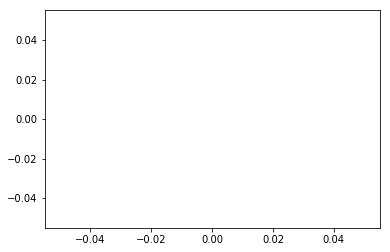

In [96]:
xs = range(len(theta_rmses))
plt.plot(xs, numpy.multiply(1,theta_rmses), 'r--')
plt.plot(xs, beta_rmses, 'bs')
plt.show()